In [1]:
!pip install torch torchvision scikit-learn matplotlib ultralytics umap

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.0 MB/s eta 0:00:00
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3541 sha256=85dd

# Import Dataset

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="J1rWUvuwvKwOyLI5ooEK")
project = rf.workspace("sanjana-kazi-supti-ymhu2").project("final-1yr0d-wo5ot")
version = project.version(1)
dataset = version.download("coco")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 88.7 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30


Extracting Dataset Version Zip to Final-1 in coco:: 100%|██████████| 4295/4295 [00:01<00:00, 3324.66it/s]


# Fix the error in the json file

In [3]:
import json
from pathlib import Path

# ===== Path to your COCO dataset folder =====
dataset_dir = Path("/kaggle/working/Final-1")

# ===== Function to convert JSON to single-class =====
def convert_to_one_class(json_file):
    with open(json_file, "r") as f:
        coco_data = json.load(f)

    # Step 1: Keep only one category
    coco_data["categories"] = [{"id": 1, "name": "Sunflower"}]

    # Step 2: Remap all annotations to category_id = 1
    for ann in coco_data["annotations"]:
        ann["category_id"] = 1

    # Step 3: Save back (overwrite original)
    with open(json_file, "w") as f:
        json.dump(coco_data, f, indent=2)

    print(f"Converted: {json_file}")

# ===== Loop over train, valid, test annotation files =====
for split in ["train", "valid", "test"]:
    json_path = dataset_dir / split / "_annotations.coco.json"
    if json_path.exists():
        convert_to_one_class(json_path)
    else:
        print(f"⚠ No JSON file found for {split}")

print("All done! Update YAML with:")
print('nc: 1\nnames: ["Sunflower"]')


Converted: /kaggle/working/Final-1/train/_annotations.coco.json
Converted: /kaggle/working/Final-1/valid/_annotations.coco.json
Converted: /kaggle/working/Final-1/test/_annotations.coco.json
All done! Update YAML with:
nc: 1
names: ["Sunflower"]


# Setup

In [4]:
import os, json, yaml, math, gc, random, shutil, contextlib
from pathlib import Path
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


# Path Declaration and COCO --> YOLO Conversion

In [5]:
import json
import shutil
import random
from pathlib import Path
import yaml
from ultralytics import YOLO

# ================================
# 1. Define Paths
# ================================
COCO_ROOT     =  Path("/kaggle/working/Final-1")  # folder with train/ and valid/
TRAIN_IMG_DIR = COCO_ROOT / "train"
TRAIN_ANN     = TRAIN_IMG_DIR / "_annotations.coco.json"
VAL_IMG_DIR   = COCO_ROOT / "valid"
VAL_ANN       = VAL_IMG_DIR / "_annotations.coco.json"

WORK          = Path("/kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset")
SPLIT         = WORK / "0_yolo_split"       # YOLO-format dataset split
PSEUDO        = WORK / "1_pseudo"           # Pseudo-label storage
STU_ROOT      = WORK / "2_student"          # Student dataset (GT + pseudo)

# ================================
# 2. Create Folder Structure
# ================================
for split in ["train", "valid", "test"]:
    (SPLIT / split / "images").mkdir(parents=True, exist_ok=True)
    (SPLIT / split / "labels").mkdir(parents=True, exist_ok=True)

(PSEUDO / "raw").mkdir(parents=True, exist_ok=True)

for split in ["train", "valid"]:
    (STU_ROOT / split / "images").mkdir(parents=True, exist_ok=True)
    (STU_ROOT / split / "labels").mkdir(parents=True, exist_ok=True)

# ================================
# 3. Load Classes from COCO
# ================================
cats = json.load(open(TRAIN_ANN))["categories"]
names = [c["name"] for c in sorted(cats, key=lambda x: x["id"])]
nc = len(names)

# ================================
# 4. COCO → YOLO Conversion
# ================================
def coco2yolo(b, w, h):
    x, y, ww, hh = b
    return (x + ww / 2) / w, (y + hh / 2) / h, ww / w, hh / h

def convert_split(split, img_dir, ann_json):
    coco = json.load(open(ann_json))
    id2img = {img["id"]: img for img in coco["images"]}
    out_im = SPLIT / split / "images"
    out_lb = SPLIT / split / "labels"

    # Write YOLO label files
    for ann in coco["annotations"]:
        img = id2img[ann["image_id"]]
        w, h = img["width"], img["height"]
        yb = coco2yolo(ann["bbox"], w, h)
        cls = ann["category_id"] - 1
        p = out_lb / f"{Path(img['file_name']).stem}.txt"
        with open(p, "a") as f:
            f.write(f"{cls} " + " ".join(f"{v:.6f}" for v in yb) + "\n")

    # Copy images
    for img in coco["images"]:
        shutil.copy(Path(img_dir) / img["file_name"], out_im / img["file_name"])

convert_split("train", TRAIN_IMG_DIR, TRAIN_ANN)
convert_split("valid", VAL_IMG_DIR, VAL_ANN)
convert_split("test", TRAIN_IMG_DIR, TRAIN_ANN)  # Use train as test if no separate test set
print("COCO to YOLO conversion completed.")

COCO to YOLO conversion completed.


# Dataset splitting and directory setup for teacher-student training

In [6]:
# ================================
# 5. Split labeled/unlabeled data from 20% labeled portion
# ================================
LABELED_RATIO = 0.2
random.seed(42)

all_train_images = list((SPLIT / "train" / "images").glob("*.jpg"))
random.shuffle(all_train_images)

num_labeled = int(len(all_train_images) * LABELED_RATIO)
labeled_images = all_train_images[:num_labeled]
unlabeled_images = all_train_images[num_labeled:]

print(f"Total train images: {len(all_train_images)}")
print(f"Labeled images (20%): {len(labeled_images)}")
print(f"Unlabeled images (80%): {len(unlabeled_images)}")

# Further split labeled into train (90%) and val (10%)
val_ratio = 0.1
num_val = int(len(labeled_images) * val_ratio)
random.shuffle(labeled_images)
val_images = labeled_images[:num_val]
train_images_for_teacher = labeled_images[num_val:]

print(f"Teacher train images (90% of 20%): {len(train_images_for_teacher)}")
print(f"Teacher val images (10% of 20%): {len(val_images)}")

# Create directories
LABELED_TRAIN_IMG_DIR = WORK / "labeled_train" / "images"
LABELED_TRAIN_LB_DIR  = WORK / "labeled_train" / "labels"
LABELED_VAL_IMG_DIR   = WORK / "labeled_val" / "images"
LABELED_VAL_LB_DIR    = WORK / "labeled_val" / "labels"
UNLABELED_IMG_DIR     = WORK / "unlabeled" / "images"

for d in [LABELED_TRAIN_IMG_DIR, LABELED_TRAIN_LB_DIR, LABELED_VAL_IMG_DIR, LABELED_VAL_LB_DIR, UNLABELED_IMG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Copy train images + labels
for img_path in train_images_for_teacher:
    shutil.copy(img_path, LABELED_TRAIN_IMG_DIR / img_path.name)
    label_path = SPLIT / "train" / "labels" / f"{img_path.stem}.txt"
    if label_path.exists():
        shutil.copy(label_path, LABELED_TRAIN_LB_DIR / label_path.name)

# Copy val images + labels
for img_path in val_images:
    shutil.copy(img_path, LABELED_VAL_IMG_DIR / img_path.name)
    label_path = SPLIT / "train" / "labels" / f"{img_path.stem}.txt"
    if label_path.exists():
        shutil.copy(label_path, LABELED_VAL_LB_DIR / label_path.name)

# Copy unlabeled images only
for img_path in unlabeled_images:
    shutil.copy(img_path, UNLABELED_IMG_DIR / img_path.name)

# Copy validation set (from original valid) to STU_ROOT for student eval
(STU_ROOT / "valid" / "images").mkdir(parents=True, exist_ok=True)
(STU_ROOT / "valid" / "labels").mkdir(parents=True, exist_ok=True)
for img in (SPLIT / "valid" / "images").glob("*.*"):
    shutil.copy(img, STU_ROOT / "valid" / "images" / img.name)
    lbl = SPLIT / "valid" / "labels" / f"{img.stem}.txt"
    if lbl.exists():
        shutil.copy(lbl, STU_ROOT / "valid" / "labels" / lbl.name)

# Copy teacher training set to STU_ROOT/train (needed for pseudo-label merging)
(STU_ROOT / "train" / "images").mkdir(parents=True, exist_ok=True)
(STU_ROOT / "train" / "labels").mkdir(parents=True, exist_ok=True)
for img_path in train_images_for_teacher:
    shutil.copy(img_path, STU_ROOT / "train" / "images" / img_path.name)
    label_path = SPLIT / "train" / "labels" / f"{img_path.stem}.txt"
    if label_path.exists():
        shutil.copy(label_path, STU_ROOT / "train" / "labels" / label_path.name)

print("Data splitting and copying done.")

Total train images: 3957
Labeled images (20%): 791
Unlabeled images (80%): 3166
Teacher train images (90% of 20%): 712
Teacher val images (10% of 20%): 79
Data splitting and copying done.


# Dataset YAML preparation for teacher–student pipeline

In [7]:
# ================================
# 6. Prepare YAML files
# ================================
teacher_data_yaml = {
    'path': str(WORK / "labeled_train"),
    'train': 'images',
    'val': str(LABELED_VAL_IMG_DIR),  # Use absolute path for val
    'nc': nc,
    'names': names
}
teacher_data_yaml_path = WORK / "teacher_data.yaml"
teacher_data_yaml_path.write_text(yaml.dump(teacher_data_yaml))

student_data_yaml = {
    'path': str(STU_ROOT),
    'train': 'train/images',
    'val': 'valid/images',
    'nc': nc,
    'names': names
}
student_data_yaml_path = WORK / "data_Sunflower_student.yaml"
student_data_yaml_path.write_text(yaml.dump(student_data_yaml))

print("YAML files prepared.")

YAML files prepared.


# Two-phase teacher training: freeze backbone, then unfreeze for fine-tuning

In [8]:
# ================================
# 7. Teacher training with frozen backbone then fine-tuning
# ================================

# Use pretrained YOLOv12s instead of local best.pt
teacher = YOLO("yolo12s.pt")  

# Freeze first 25% backbone layers
backbone = teacher.model.model[0]
backbone_layers = list(backbone.children())
total_layers = len(backbone_layers)
freeze_count = int(total_layers * 0.25)
for i, layer in enumerate(backbone_layers):
    if i < freeze_count:
        layer.eval()
        for param in layer.parameters():
            param.requires_grad = False
print(f"Frozen {freeze_count}/{total_layers} backbone layers.")

teacher.train(
    data=str(teacher_data_yaml_path),
    epochs=5,
    imgsz=640,
    batch=12,
    project=str(WORK),
    name="teacher_partial_freeze",
    device=0,
    lr0=0.001,
    lrf=0.1,
    momentum=0.937,
    weight_decay=0.0005,
    cos_lr=True,
    save=True,
)

# Unfreeze all layers for fine-tuning
for param in teacher.model.parameters():
    param.requires_grad = True
print("All layers unfrozen for fine-tuning.")

last_checkpoint = WORK / "teacher_partial_freeze" / "weights" / "last.pt"

teacher.train(
    data=str(teacher_data_yaml_path),
    epochs=50,
    imgsz=640,
    batch=12,
    project=str(WORK),
    name="teacher_final",
    device=0,
    lr0=0.0005,
    lrf=0.05,
    momentum=0.937,
    weight_decay=0.0005,
    cos_lr=True,
    save=True,
    resume=False,
    pretrained=str(last_checkpoint)  # load last checkpoint from frozen phase
)

teacher_weights = WORK / "teacher_final" / "weights" / "best.pt"
print(f"Teacher final model saved to {teacher_weights}")


Frozen 0/3 backbone layers.
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=teacher_partial_freeze, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, o

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    689408  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1812.2±637.9 MB/s, size: 86.7 KB)


train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_train/labels... 712 images, 0 backgrounds, 0 corrupt: 100%|██████████| 712/712 [00:00<00:00, 1086.22it/s]

train: New cache created: /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.1±0.2 ms, read: 374.2±50.3 MB/s, size: 91.1 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_val/labels... 79 images, 0 backgrounds, 0 corrupt: 100%|██████████| 79/79 [00:00<00:00, 670.88it/s]

val: New cache created: /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_val/labels.cache


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      6.98G      1.824      1.329      1.241        596        640: 100%|██████████| 60/60 [00:23<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


                   all         79       5726      0.696      0.676      0.709      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.04G      1.656     0.9216      1.146        475        640: 100%|██████████| 60/60 [00:20<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]

                   all         79       5726      0.765      0.694      0.778      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.08G      1.581      0.875      1.117        265        640: 100%|██████████| 60/60 [00:20<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

                   all         79       5726      0.802      0.762      0.841      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.12G      1.534     0.8317      1.084        422        640: 100%|██████████| 60/60 [00:21<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

                   all         79       5726      0.799      0.761      0.839      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      7.16G      1.462     0.7795      1.057        536        640: 100%|██████████| 60/60 [00:21<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all         79       5726      0.835      0.779      0.866      0.513



5 epochs completed in 0.033 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze/weights/best.pt...
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  2.00s/it]
invalid value encountered in less
invalid value encountered in less


                   all         79       5726      0.835      0.779      0.866      0.513
Speed: 0.5ms preprocess, 56.7ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_partial_freeze
All layers unfrozen for fine-tuning.
Transferred 691/691 items from pretrained weights
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_train/labels.cache... 712 images, 0 backgrounds, 0 corrupt: 100%|██████████| 712/712 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 1.0±2.2 ms, read: 373.7±31.7 MB/s, size: 91.1 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_val/labels.cache... 79 images, 0 backgrounds, 0 corrupt: 100%|██████████| 79/79 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.02G      1.455     0.7791      1.044        596        640: 100%|██████████| 60/60 [00:23<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all         79       5726        0.8      0.769      0.819      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.05G      1.511     0.8157      1.073        475        640: 100%|██████████| 60/60 [00:22<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

                   all         79       5726      0.827      0.735      0.836      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.09G      1.553     0.8353      1.097        265        640: 100%|██████████| 60/60 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all         79       5726       0.79      0.727      0.793      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.09G      1.582     0.8437      1.092        422        640: 100%|██████████| 60/60 [00:22<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]

                   all         79       5726      0.822       0.73      0.831      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      7.09G      1.519     0.8165      1.071        536        640: 100%|██████████| 60/60 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all         79       5726      0.805      0.755      0.841      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      7.13G      1.531     0.8225      1.078        522        640: 100%|██████████| 60/60 [00:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]

                   all         79       5726      0.827       0.76       0.85      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      7.98G      1.501     0.8084       1.07        374        640: 100%|██████████| 60/60 [00:21<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all         79       5726       0.82      0.789      0.861      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      7.62G        1.5     0.8155      1.066        599        640: 100%|██████████| 60/60 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]

                   all         79       5726      0.805      0.779      0.847      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.85G      1.511     0.8092      1.072        572        640: 100%|██████████| 60/60 [00:21<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]

                   all         79       5726      0.824      0.777      0.858       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.57G      1.475     0.7905      1.062        433        640: 100%|██████████| 60/60 [00:21<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all         79       5726      0.836      0.787      0.877      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.17G      1.449     0.7805      1.049        233        640: 100%|██████████| 60/60 [00:21<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all         79       5726      0.817       0.78      0.863      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.17G      1.458     0.7765       1.05        603        640: 100%|██████████| 60/60 [00:22<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]

                   all         79       5726       0.83       0.78      0.865      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.21G      1.426      0.761      1.037        541        640: 100%|██████████| 60/60 [00:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all         79       5726      0.816      0.808      0.872      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.25G      1.423     0.7513      1.037        359        640: 100%|██████████| 60/60 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]

                   all         79       5726      0.817      0.799      0.868      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.79G       1.42     0.7468      1.036        837        640: 100%|██████████| 60/60 [00:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

                   all         79       5726      0.831      0.792      0.872      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.24G      1.421     0.7455      1.033        459        640: 100%|██████████| 60/60 [00:21<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

                   all         79       5726      0.825      0.798      0.871      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.24G      1.399     0.7344      1.032        408        640: 100%|██████████| 60/60 [00:21<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all         79       5726      0.844      0.787      0.878       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         8G      1.397     0.7314      1.036        543        640: 100%|██████████| 60/60 [00:21<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]

                   all         79       5726      0.824      0.801      0.875      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      7.26G      1.399     0.7308      1.025        406        640: 100%|██████████| 60/60 [00:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]

                   all         79       5726       0.85      0.806      0.888       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      7.26G      1.386     0.7243      1.022        313        640: 100%|██████████| 60/60 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all         79       5726      0.845      0.803      0.884       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      7.29G      1.375     0.7164      1.029        499        640: 100%|██████████| 60/60 [00:22<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all         79       5726      0.846      0.794       0.88      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      7.33G      1.385     0.7127      1.022        317        640: 100%|██████████| 60/60 [00:21<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]

                   all         79       5726      0.839      0.796      0.881      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      7.37G      1.374     0.7068      1.015        331        640: 100%|██████████| 60/60 [00:21<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

                   all         79       5726      0.843      0.809       0.89      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.16G      1.364     0.7015      1.008        301        640: 100%|██████████| 60/60 [00:22<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

                   all         79       5726      0.846      0.808       0.89      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.16G      1.335     0.6885      1.011        269        640: 100%|██████████| 60/60 [00:21<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

                   all         79       5726      0.836      0.822      0.894      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       6.2G      1.338     0.6969      1.014        495        640: 100%|██████████| 60/60 [00:21<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all         79       5726      0.853      0.812       0.89       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.24G      1.341     0.6914      1.011        690        640: 100%|██████████| 60/60 [00:21<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]

                   all         79       5726      0.848      0.811       0.89      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.28G      1.332     0.6837      1.005        442        640: 100%|██████████| 60/60 [00:21<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

                   all         79       5726      0.853      0.806      0.892      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.32G      1.321     0.6724      1.001        531        640: 100%|██████████| 60/60 [00:21<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all         79       5726      0.851      0.809      0.891      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.32G      1.329     0.6731      1.002        292        640: 100%|██████████| 60/60 [00:22<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]

                   all         79       5726       0.85      0.817      0.895      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.32G      1.311     0.6696     0.9976        257        640: 100%|██████████| 60/60 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all         79       5726      0.854      0.809      0.894      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.32G      1.313     0.6611     0.9899        507        640: 100%|██████████| 60/60 [00:21<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

                   all         79       5726       0.86      0.803      0.895      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.32G        1.3     0.6587     0.9921        360        640: 100%|██████████| 60/60 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

                   all         79       5726      0.854      0.813      0.896      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.32G      1.301     0.6565      0.994        265        640: 100%|██████████| 60/60 [00:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all         79       5726      0.868      0.808      0.898      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.32G       1.29     0.6496      0.994        307        640: 100%|██████████| 60/60 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all         79       5726      0.853      0.812      0.898      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.32G      1.285     0.6466     0.9874        594        640: 100%|██████████| 60/60 [00:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

                   all         79       5726      0.859      0.819      0.899      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.32G      1.274      0.646     0.9825        296        640: 100%|██████████| 60/60 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all         79       5726      0.862      0.815      0.902      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.32G      1.273     0.6427      0.986        575        640: 100%|██████████| 60/60 [00:21<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

                   all         79       5726      0.855      0.813      0.897      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.32G      1.283     0.6418     0.9833        182        640: 100%|██████████| 60/60 [00:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all         79       5726      0.866      0.816      0.901      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.32G      1.273     0.6398     0.9834        331        640: 100%|██████████| 60/60 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all         79       5726      0.857      0.818      0.901      0.561


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.32G      1.272     0.6383          1        160        640: 100%|██████████| 60/60 [00:21<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all         79       5726      0.864      0.821      0.901      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.32G      1.264     0.6282     0.9958        338        640: 100%|██████████| 60/60 [00:20<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all         79       5726      0.851      0.824        0.9      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.32G      1.253     0.6177     0.9906        205        640: 100%|██████████| 60/60 [00:20<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all         79       5726      0.858      0.823      0.902      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.36G      1.247     0.6155     0.9861        218        640: 100%|██████████| 60/60 [00:20<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all         79       5726      0.864      0.823      0.902      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.36G      1.246     0.6084      0.984        320        640: 100%|██████████| 60/60 [00:20<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

                   all         79       5726      0.858      0.825      0.905      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.36G      1.228     0.6042     0.9768        256        640: 100%|██████████| 60/60 [00:20<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

                   all         79       5726      0.861      0.828      0.906       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.36G       1.23      0.602     0.9802        222        640: 100%|██████████| 60/60 [00:20<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all         79       5726      0.863      0.828      0.905      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.36G      1.227     0.5991     0.9781        314        640: 100%|██████████| 60/60 [00:20<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]

                   all         79       5726      0.861       0.83      0.903       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.36G      1.226     0.6005     0.9767        307        640: 100%|██████████| 60/60 [00:20<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

                   all         79       5726      0.866      0.828      0.905      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.36G      1.221     0.5953     0.9754        378        640: 100%|██████████| 60/60 [00:20<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all         79       5726      0.869      0.825      0.906      0.579



50 epochs completed in 0.331 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/weights/best.pt...
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.11s/it]
invalid value encountered in less
invalid value encountered in less


                   all         79       5726      0.862      0.828      0.906       0.58
Speed: 0.3ms preprocess, 9.9ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final
Teacher final model saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/teacher_final/weights/best.pt


# Training metrics and result plots for teacher YOLO model

Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


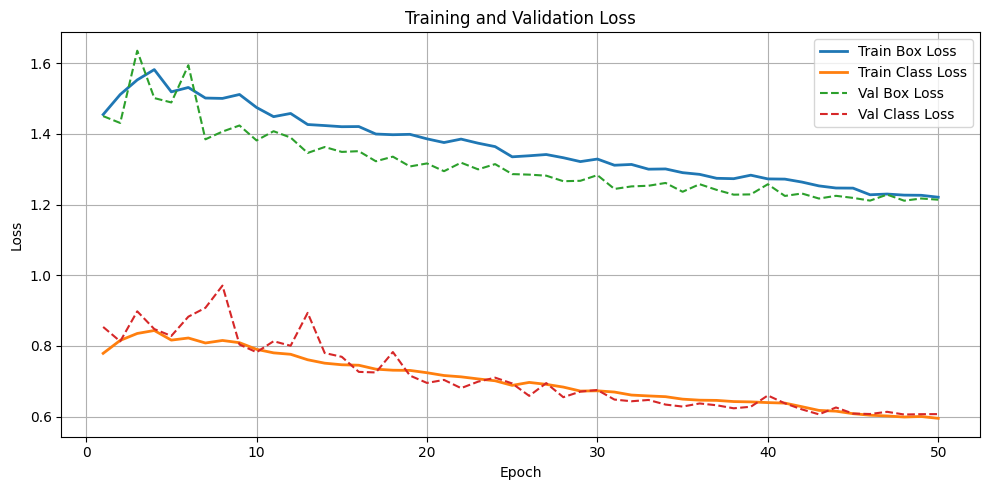

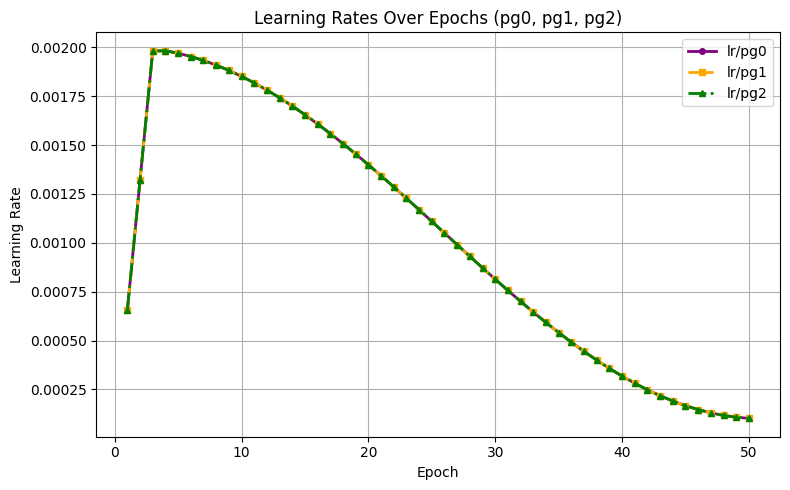

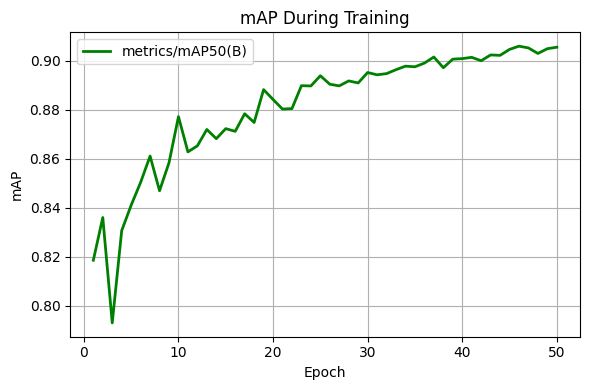

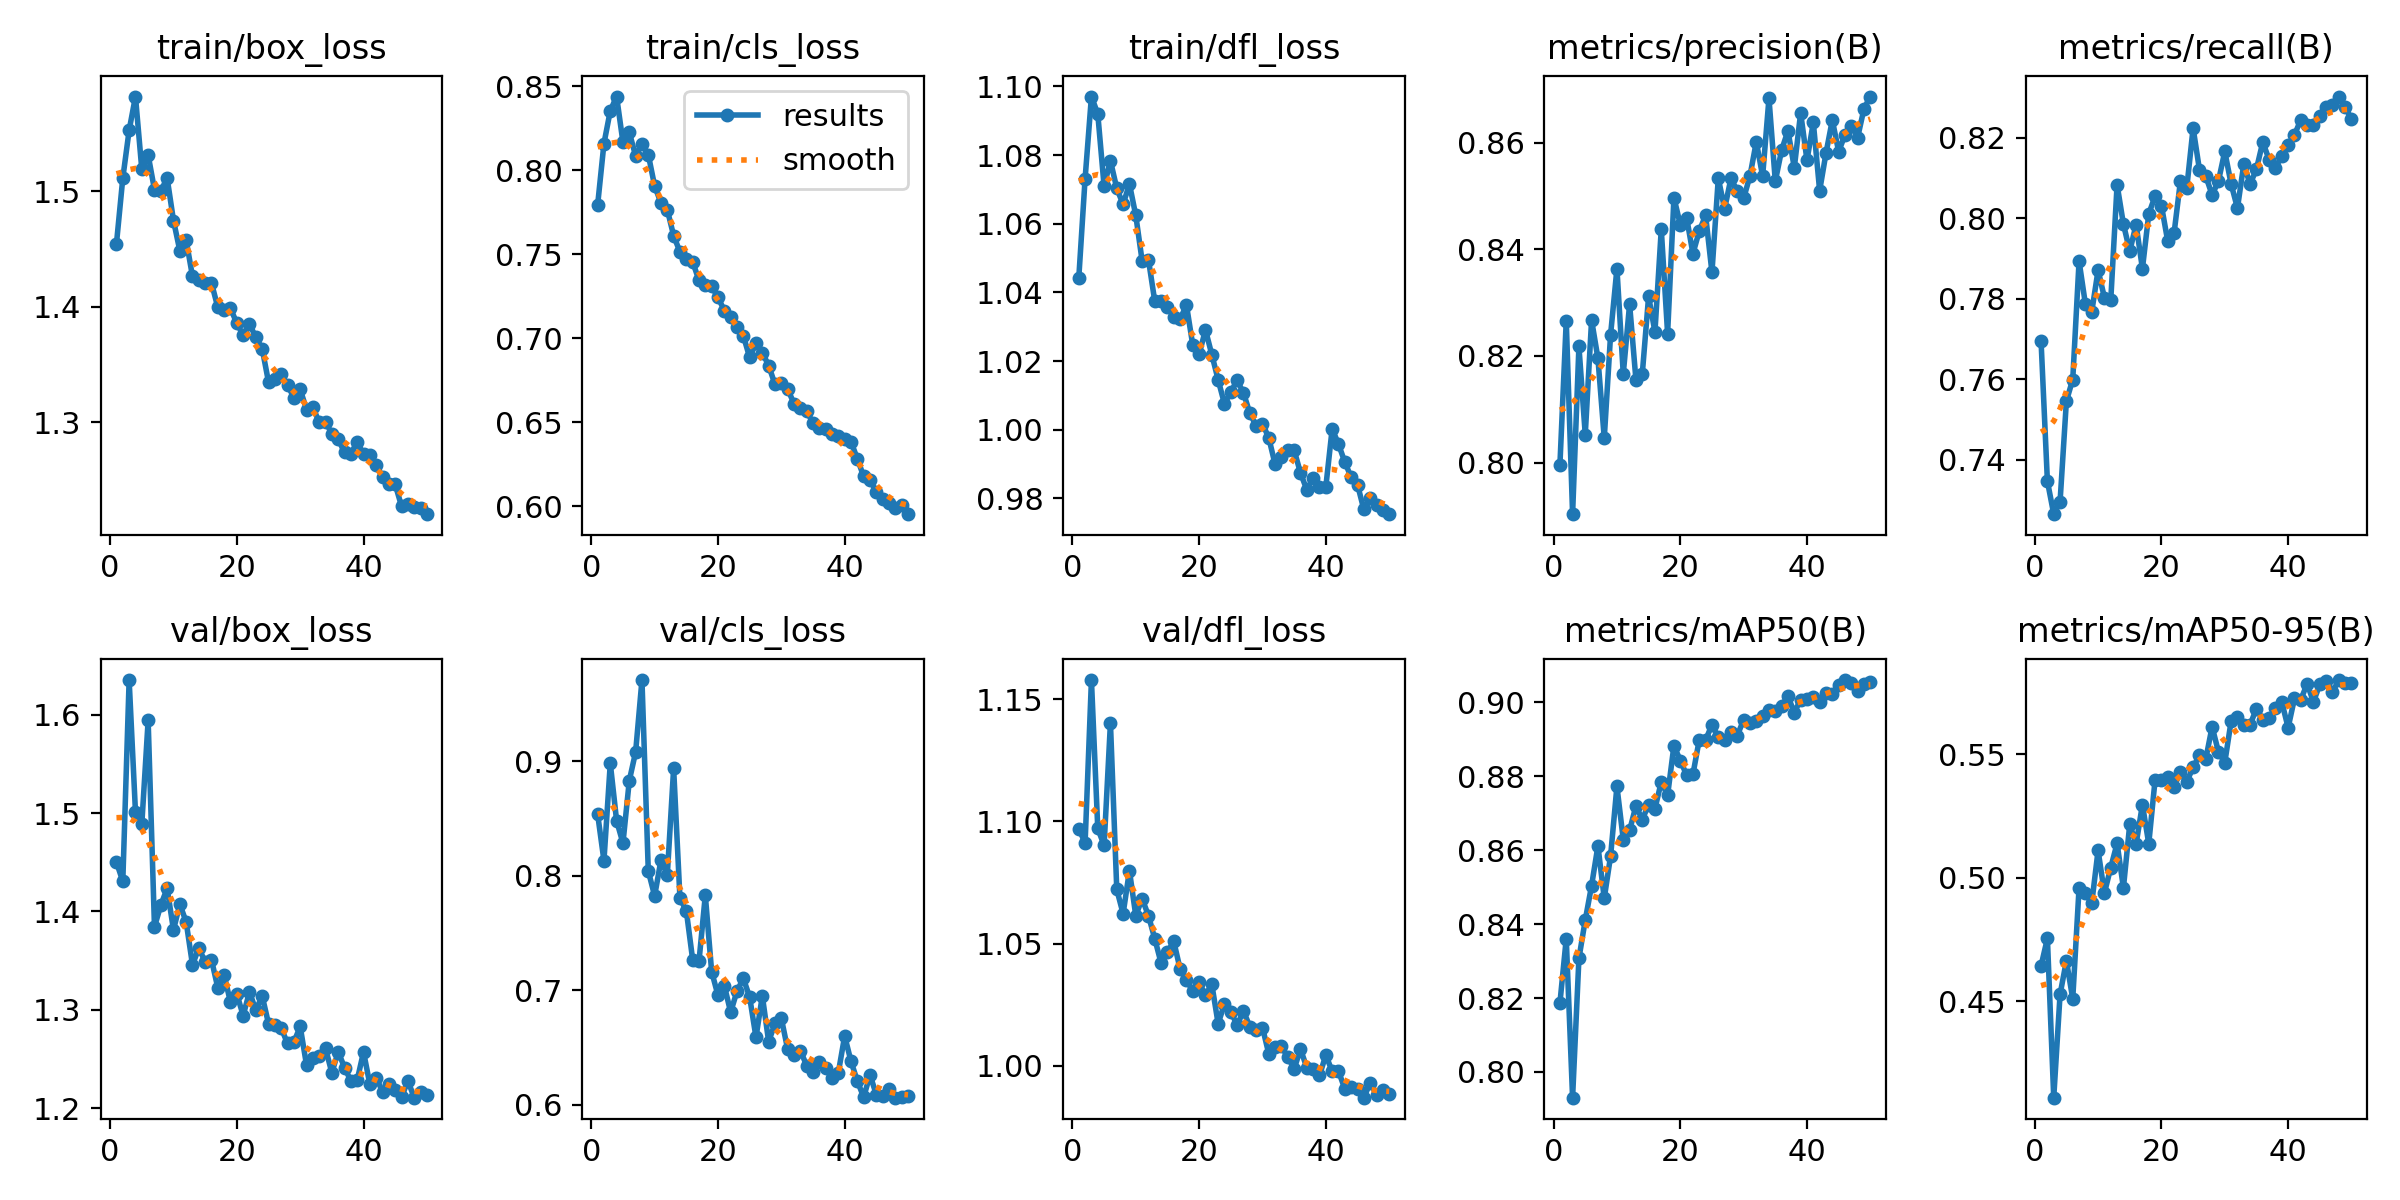

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Path to results.csv
results_path = WORK / "teacher_final" / "results.csv"

# Load CSV
df = pd.read_csv(results_path)

# Show available columns
print("Available columns:", df.columns.tolist())

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
colors = ['purple', 'orange', 'green']
styles = ['-', '--', '-.']
markers = ['o', 's', '^']

if lr_columns:
    plt.figure(figsize=(8, 5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")


# Plot mAP Curve (0.5 IoU)
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)"]  # version dependent
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(6, 4))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")



from PIL import Image
from IPython.display import display

results_img = WORK / "teacher_final" / "results.png"
img = Image.open(results_img)
display(img)

# Semi-supervised training using STAC: teacher generates pseudo-labels, student learns iteratively

In [10]:
# ================================
# 8. STAC-style self-training loop
# ================================
IMGZ = 640
TAU = 0.7
STAC_ITERS = 5
STU_EPOCHS = 50
BATCH = 12
DEVICE = "0"  # Change to "cpu" if no GPU available

print("Starting STAC self-training...")

for it in range(STAC_ITERS):
    print(f"\n=== STAC iteration {it+1}/{STAC_ITERS} ===")

    # 1. Generate pseudo-labels on UNLABELED images
    raw_label_dir = PSEUDO / "raw" / "labels"
    if raw_label_dir.exists():
        shutil.rmtree(raw_label_dir)
    raw_label_dir.mkdir(parents=True, exist_ok=True)

    print(f"Generating pseudo-labels on {len(list(UNLABELED_IMG_DIR.glob('*.*')))} unlabeled images...")
    YOLO(str(teacher_weights)).predict(
        source=str(UNLABELED_IMG_DIR),
        save_txt=True,
        save_conf=True,
        conf=TAU,
        project=str(PSEUDO),
        name="raw",
        device=DEVICE,
        imgsz=IMGZ,
        verbose=True,
    )

    # 2. Prepare student training labels by merging GT + pseudo labels
    labels_dir = STU_ROOT / "train" / "labels"
    # Clear existing student train labels
    for f in labels_dir.glob("*.txt"):
        f.unlink()

    # Copy ground-truth labels from labeled_train (teacher training GT)
    labeled_gt_dir = WORK / "labeled_train" / "labels"
    for gt_file in labeled_gt_dir.glob("*.txt"):
        shutil.copy(gt_file, labels_dir / gt_file.name)

        # If pseudo label exists for same image (only unlabeled images won't have GT)
        pseudo_file = raw_label_dir / gt_file.name
        if pseudo_file.exists():
            with open(labels_dir / gt_file.name, "a") as d, open(pseudo_file, "r") as p:
                d.write(p.read())

    # Add pseudo labels for unlabeled images (which have no GT)
    for pseudo_file in raw_label_dir.glob("*.txt"):
        if not (labels_dir / pseudo_file.name).exists():
            # This pseudo label corresponds to an unlabeled image
            # Copy it directly as student label
            shutil.copy(pseudo_file, labels_dir / pseudo_file.name)

    # Copy labeled + unlabeled images to STU_ROOT/train/images for student training
    # Clear previous images first
    images_dir = STU_ROOT / "train" / "images"
    for f in images_dir.glob("*.*"):
        f.unlink()

    # Copy labeled train images
    labeled_train_images = list((WORK / "labeled_train" / "images").glob("*.*"))
    for img in labeled_train_images:
        shutil.copy(img, images_dir / img.name)

    # Copy unlabeled images (pseudo-labeled) also
    unlabeled_images = list(UNLABELED_IMG_DIR.glob("*.*"))
    for img in unlabeled_images:
        shutil.copy(img, images_dir / img.name)

    print(f"Prepared training set: {len(list(images_dir.glob('*.*')))} images with merged labels.")

    # 3. Train student model on combined dataset
    student = YOLO(str(teacher_weights))
    student.train(
        data=str(WORK / "data_Sunflower_student.yaml"),  # your student YAML path
        epochs=STU_EPOCHS,
        imgsz=IMGZ,
        batch=BATCH,
        project=str(WORK),
        name=f"student_it{it+1}",
        device=DEVICE,
        verbose=True,
    )

    # 4. Update teacher weights to student's best weights for next iteration
    new_teacher_weights = WORK / f"student_it{it+1}" / "weights" / "best.pt"
    if not new_teacher_weights.exists():
        raise FileNotFoundError(f"Student weights not found: {new_teacher_weights}")
    teacher_weights = new_teacher_weights
    print(f"Teacher weights updated to iteration {it+1}'s student best weights.")

print("STAC self-training complete.")

Starting STAC self-training...

=== STAC iteration 1/5 ===
Generating pseudo-labels on 3166 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/3166 /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/unlabeled/images/20240116_122814-mp4_frame11_jpg.rf.650cefb9416fc89e311a7aff32bdf073.jpg: 640x640 60 Sunflowers, 20.8ms
image 2/3166 /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/unlabeled/images/20240116_122814-mp4_frame11_jpg.rf.89dbffb6bc606c0c43f3f6083ba9dd86.jpg: 64

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels... 712 images, 3166 backgrounds, 0 corrupt: 100%|██████████| 3878/3878 [00:02<00:00, 1921.70it/s]


train: New cache created: /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 468.3±393.3 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<00:00, 552.24it/s]


val: New cache created: /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache
Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.81G      1.357      13.21      1.012         12        640: 100%|██████████| 324/324 [01:54<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.841      0.767      0.864      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.94G      1.489      2.398      1.071        297        640: 100%|██████████| 324/324 [01:50<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.597      0.869      0.818      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.02G      1.569      2.176      1.096          0        640: 100%|██████████| 324/324 [01:49<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.362      0.929      0.825      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.23G       1.57      4.093      1.104          0        640: 100%|██████████| 324/324 [01:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.796      0.768      0.839      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       6.9G      1.572      2.115      1.113          1        640: 100%|██████████| 324/324 [01:48<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823       0.51      0.908      0.835      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.23G      1.528      2.951      1.072         26        640: 100%|██████████| 324/324 [01:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.768      0.806      0.842      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.51G      1.533      2.059      1.087        276        640: 100%|██████████| 324/324 [01:48<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.758      0.808      0.836      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.51G       1.53      2.131      1.078          9        640: 100%|██████████| 324/324 [01:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]

                   all        165      13823      0.727      0.827      0.837      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.78G      1.503      2.096       1.07          0        640: 100%|██████████| 324/324 [01:49<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.718      0.859      0.857      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         6G      1.488      3.067      1.067        129        640: 100%|██████████| 324/324 [01:48<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823      0.723      0.846       0.85      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.33G       1.48      2.774      1.067         33        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.537       0.92      0.857      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.38G      1.482      2.014      1.063          2        640: 100%|██████████| 324/324 [01:48<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.868      0.705      0.845      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       5.5G       1.46      3.478      1.052         56        640: 100%|██████████| 324/324 [01:48<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823       0.81      0.812      0.875      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.02G      1.437      2.107      1.054          0        640: 100%|██████████| 324/324 [01:48<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.703      0.876      0.866      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.06G      1.445      2.675      1.053         19        640: 100%|██████████| 324/324 [01:48<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.798      0.817      0.868      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.08G      1.431      1.954      1.049         40        640: 100%|██████████| 324/324 [01:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.752      0.824      0.841      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.14G      1.432      3.032      1.042          0        640: 100%|██████████| 324/324 [01:48<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.605      0.914      0.869      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.18G      1.413       2.15      1.035          0        640: 100%|██████████| 324/324 [01:48<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823      0.681      0.883      0.861      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.22G       1.43      2.697      1.037         10        640: 100%|██████████| 324/324 [01:48<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823       0.58      0.924      0.872      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.25G      1.406      2.045      1.028          0        640: 100%|██████████| 324/324 [01:48<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823      0.728      0.868       0.86      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.27G      1.403       2.09      1.036         63        640: 100%|██████████| 324/324 [01:48<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.776      0.828       0.87      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.33G      1.388      1.966      1.041        156        640: 100%|██████████| 324/324 [01:48<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823       0.78      0.816       0.86      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.37G      1.389      2.151       1.04         75        640: 100%|██████████| 324/324 [01:48<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.754      0.851      0.856      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.41G      1.373      1.929      1.022         37        640: 100%|██████████| 324/324 [01:48<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.787      0.845      0.882      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.45G      1.376      2.122      1.037         33        640: 100%|██████████| 324/324 [01:48<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.814      0.745      0.843        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.47G      1.369      2.881       1.02         11        640: 100%|██████████| 324/324 [01:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.847      0.771      0.868      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.53G      1.366      2.037      1.019         27        640: 100%|██████████| 324/324 [01:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823       0.81      0.831      0.883      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.57G      1.352      1.958      1.031          6        640: 100%|██████████| 324/324 [01:48<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.792      0.833      0.872      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.61G      1.338      2.301      1.016         20        640: 100%|██████████| 324/324 [01:48<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.861      0.775      0.884      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.64G      1.345      3.257      1.017          0        640: 100%|██████████| 324/324 [01:48<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.832      0.805      0.873      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.66G      1.357      1.917      1.022         65        640: 100%|██████████| 324/324 [01:48<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.785      0.845      0.875      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      7.22G      1.334      1.978      1.018          8        640: 100%|██████████| 324/324 [01:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.793      0.798      0.846      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      7.26G      1.335      3.061      1.015         23        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.767      0.849      0.863      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       7.3G      1.329      2.165      1.016          0        640: 100%|██████████| 324/324 [01:48<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823       0.75      0.864       0.87      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      7.34G      1.317      1.928      1.004         19        640: 100%|██████████| 324/324 [01:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.68it/s]

                   all        165      13823      0.862      0.778      0.878      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      7.36G      1.307      2.899      1.011        100        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.795       0.84      0.872       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      7.41G      1.293      2.853     0.9962          0        640: 100%|██████████| 324/324 [01:48<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.749      0.877      0.875      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.08G      1.316      2.108      1.003          0        640: 100%|██████████| 324/324 [01:48<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.811      0.831      0.875      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.08G      1.315      2.162      1.005         41        640: 100%|██████████| 324/324 [01:48<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823      0.829      0.806      0.874      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.08G      1.306      1.884      1.002          2        640: 100%|██████████| 324/324 [01:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.785      0.843      0.864       0.51


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.08G      1.192      15.42      0.931          0        640: 100%|██████████| 324/324 [01:48<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

                   all        165      13823      0.396      0.953      0.824      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.08G      1.169      14.09     0.9272          0        640: 100%|██████████| 324/324 [01:47<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.553      0.941      0.842      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       6.1G      1.158      17.24     0.9207          0        640: 100%|██████████| 324/324 [01:47<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.615      0.921      0.853      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.14G      1.186      12.04     0.9361          0        640: 100%|██████████| 324/324 [01:47<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.726      0.882      0.849      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.18G      1.187      13.39     0.9444         30        640: 100%|██████████| 324/324 [01:47<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.679        0.9      0.844      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       6.2G      1.161      16.02     0.9283          0        640: 100%|██████████| 324/324 [01:47<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

                   all        165      13823      0.682      0.891      0.829      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.26G       1.16      16.53     0.9214          0        640: 100%|██████████| 324/324 [01:47<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.733      0.875      0.848        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       6.3G      1.166      14.21     0.9384          0        640: 100%|██████████| 324/324 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.624      0.924      0.858      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.34G      1.152      13.63     0.9269          0        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.542       0.94      0.856      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.38G       1.15      13.38     0.9297         44        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.505      0.946       0.84      0.502



50 epochs completed in 1.559 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1/weights/best.pt...
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823      0.861      0.775      0.884      0.543
Speed: 0.2ms preprocess, 10.0ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it1
Teacher weights updated to iteration 1's student best weights.

=== STAC iteration 2/5 ===
Generating pseudo-labels on 3166 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/3166 /kaggle/working/PSEUDO_STAC/Pseudo_Converted_

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache... 712 images, 3166 backgrounds, 0 corrupt: 100%|██████████| 3878/3878 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 421.1±54.9 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.98G       1.32      3.101      1.004         12        640: 100%|██████████| 324/324 [01:55<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.825      0.794      0.864      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.97G      1.347      2.175      1.021        297        640: 100%|██████████| 324/324 [01:51<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.714      0.863      0.857      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.05G      1.394      2.038      1.031          0        640: 100%|██████████| 324/324 [01:50<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.66it/s]

                   all        165      13823      0.332      0.938      0.849      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.26G       1.41      3.227      1.037          0        640: 100%|██████████| 324/324 [01:49<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]

                   all        165      13823      0.801      0.832      0.877      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.93G      1.403      1.985       1.05          1        640: 100%|██████████| 324/324 [01:49<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823       0.76      0.849      0.872      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.28G      1.396      2.973      1.026         26        640: 100%|██████████| 324/324 [01:50<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]

                   all        165      13823       0.78      0.836      0.869      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.54G      1.409      1.942      1.039        276        640: 100%|██████████| 324/324 [01:49<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.874      0.718      0.863      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.54G      1.403       2.04      1.031          9        640: 100%|██████████| 324/324 [01:49<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823      0.765      0.827      0.854      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       6.8G      1.388      2.005      1.031          0        640: 100%|██████████| 324/324 [01:49<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.812      0.823       0.88      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.04G      1.381      2.829      1.032        129        640: 100%|██████████| 324/324 [01:49<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.658      0.895       0.86      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.34G      1.393      2.734      1.034         33        640: 100%|██████████| 324/324 [01:49<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823      0.592      0.927      0.855      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.39G      1.386      1.955      1.027          2        640: 100%|██████████| 324/324 [01:49<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.844      0.748      0.852      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.51G      1.373      4.144      1.023         56        640: 100%|██████████| 324/324 [01:48<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.835      0.783      0.873      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.02G      1.354      2.035      1.025          0        640: 100%|██████████| 324/324 [01:48<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.727      0.869      0.863      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.06G       1.37      2.685      1.023         19        640: 100%|██████████| 324/324 [01:48<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.784      0.838      0.861      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.06G      1.354      1.891      1.023         40        640: 100%|██████████| 324/324 [01:49<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.805      0.822      0.861      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.06G      1.355      3.184      1.014          0        640: 100%|██████████| 324/324 [01:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

                   all        165      13823       0.72      0.879      0.871       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.06G      1.349      2.126       1.01          0        640: 100%|██████████| 324/324 [01:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823      0.743      0.856      0.851      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.06G        nan        nan        nan         10        640: 100%|██████████| 324/324 [01:48<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.06G      1.344      2.008      1.007          0        640: 100%|██████████| 324/324 [01:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.06G      1.331      2.034      1.012         63        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.06G        nan        nan        nan        156        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.06G        nan        nan        nan         75        640: 100%|██████████| 324/324 [01:47<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.06G       1.33      1.895      1.009         37        640: 100%|██████████| 324/324 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.06G      1.335      2.107      1.021         33        640: 100%|██████████| 324/324 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.06G      1.335      2.933      1.007         11        640: 100%|██████████| 324/324 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       6.1G      1.328       2.01      1.008         27        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       6.1G      1.317      1.929       1.02          6        640: 100%|██████████| 324/324 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       6.1G      1.313       2.27      1.005         20        640: 100%|██████████| 324/324 [01:47<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       6.1G      1.326      3.321      1.011          0        640: 100%|██████████| 324/324 [01:47<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       6.1G      1.331      1.904      1.016         65        640: 100%|██████████| 324/324 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       6.1G      1.313      1.967      1.011          8        640: 100%|██████████| 324/324 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       6.1G      1.317      3.095      1.011         23        640: 100%|██████████| 324/324 [01:47<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       6.1G      1.312      2.158      1.011          0        640: 100%|██████████| 324/324 [01:47<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       6.1G      1.303      1.922          1         19        640: 100%|██████████| 324/324 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       6.1G      1.297      2.883      1.008        100        640: 100%|██████████| 324/324 [01:47<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       6.1G      1.285        2.9     0.9903          0        640: 100%|██████████| 324/324 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       6.1G      1.307       2.11     0.9992          0        640: 100%|██████████| 324/324 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       6.1G      1.305      2.173     0.9978         41        640: 100%|██████████| 324/324 [01:47<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       6.1G      1.299      1.884     0.9974          2        640: 100%|██████████| 324/324 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        165      13823          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       6.1G       1.19      15.81     0.9279          0        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       6.1G       1.17      13.63     0.9293          0        640: 100%|██████████| 324/324 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       6.1G       1.16      17.24     0.9228          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       6.1G      1.187      12.04     0.9387          0        640: 100%|██████████| 324/324 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       6.1G      1.186      13.47     0.9445         30        640: 100%|██████████| 324/324 [01:47<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       6.1G      1.164      16.06     0.9298          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       6.1G      1.166      16.46     0.9255          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       6.1G      1.168      14.26      0.939          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       6.1G      1.158      13.88     0.9289          0        640: 100%|██████████| 324/324 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       6.1G      1.159         14     0.9335         44        640: 100%|██████████| 324/324 [01:46<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        165      13823          0          0          0          0



50 epochs completed in 1.549 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2/weights/best.pt...
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823      0.721       0.88      0.871       0.52
Speed: 0.2ms preprocess, 10.2ms inference, 0.0ms loss, 11.9ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it2
Teacher weights updated to iteration 2's student best weights.

=== STAC iteration 3/5 ===
Generating pseudo-labels on 3166 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/3166 /kaggle/working/PSEUDO_STAC/Pseudo_Converted

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache... 712 images, 3166 backgrounds, 0 corrupt: 100%|██████████| 3878/3878 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 379.4±63.5 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.82G      1.308      2.616      0.998         12        640: 100%|██████████| 324/324 [01:55<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.794       0.82      0.852      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.92G       1.31      2.154      1.005        297        640: 100%|██████████| 324/324 [01:50<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.64it/s]

                   all        165      13823      0.734      0.869      0.858      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.02G      1.351          2      1.015          0        640: 100%|██████████| 324/324 [01:50<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        165      13823      0.363      0.945       0.84       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.23G      1.355      2.907      1.022          0        640: 100%|██████████| 324/324 [01:49<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        165      13823      0.728      0.871      0.866      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.88G        nan        nan        nan          1        640: 100%|██████████| 324/324 [01:49<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.23G        nan        nan        nan         26        640: 100%|██████████| 324/324 [01:48<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.51G      1.369      1.914       1.02        276        640: 100%|██████████| 324/324 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.52G       1.36      1.998      1.014          9        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.77G      1.356      1.979      1.015          0        640: 100%|██████████| 324/324 [01:48<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.99G      1.355      2.839       1.02        129        640: 100%|██████████| 324/324 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.32G      1.368      2.682      1.024         33        640: 100%|██████████| 324/324 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.34G      1.361      1.934      1.023          2        640: 100%|██████████| 324/324 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.34G      1.343      4.153      1.015         56        640: 100%|██████████| 324/324 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      7.34G      1.328      2.017      1.015          0        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      7.34G      1.342      2.701      1.015         19        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      7.36G       1.33      1.879      1.014         40        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      7.41G      1.336      3.292      1.005          0        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.75G      1.344      2.137      1.009          0        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.32G      1.362      2.739      1.014         10        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.36G      1.342      2.003      1.006          0        640: 100%|██████████| 324/324 [01:47<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.36G      1.332      2.033      1.012         63        640: 100%|██████████| 324/324 [01:47<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.36G      1.322      1.908      1.016        156        640: 100%|██████████| 324/324 [01:47<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.36G      1.332      2.101      1.018         75        640: 100%|██████████| 324/324 [01:47<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.36G      1.315      1.883      1.004         37        640: 100%|██████████| 324/324 [01:47<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.36G      1.316      2.077      1.014         33        640: 100%|██████████| 324/324 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.36G      1.312      2.982      1.002         11        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.36G      1.316      2.006      1.003         27        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.36G      1.302      1.916      1.013          6        640: 100%|██████████| 324/324 [01:48<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.36G      1.298      2.269     0.9977         20        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.36G      1.309      3.337      1.003          0        640: 100%|██████████| 324/324 [01:47<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.36G        nan        nan        nan         65        640: 100%|██████████| 324/324 [01:47<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.36G      1.314      1.976       1.01          8        640: 100%|██████████| 324/324 [01:47<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.36G      1.325      3.097      1.012         23        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.36G      1.328       2.18      1.016          0        640: 100%|██████████| 324/324 [01:47<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.36G      1.321      1.944      1.006         19        640: 100%|██████████| 324/324 [01:47<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.36G      1.319      2.871      1.016        100        640: 100%|██████████| 324/324 [01:46<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.36G      1.304      2.892     0.9993          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.36G      1.327      2.139      1.008          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.36G      1.335      2.156       1.01         41        640: 100%|██████████| 324/324 [01:46<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.36G      1.326       1.91       1.01          2        640: 100%|██████████| 324/324 [01:47<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.36G      1.217      15.42     0.9427          0        640: 100%|██████████| 324/324 [01:47<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.36G      1.197       14.5     0.9422          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.36G      1.189       16.9     0.9339          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.36G      1.212      12.27     0.9489          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.36G      1.217      13.28     0.9574         30        640: 100%|██████████| 324/324 [01:46<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.36G      1.192      15.53     0.9408          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.36G      1.195      16.33     0.9363          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.36G      1.201       13.6     0.9519          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.36G       1.19      13.26     0.9411          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.36G      1.189      13.51     0.9458         44        640: 100%|██████████| 324/324 [01:46<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        165      13823          0          0          0          0



50 epochs completed in 1.538 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3/weights/best.pt...
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823      0.734      0.869      0.858      0.492
Speed: 0.2ms preprocess, 9.7ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it3
Teacher weights updated to iteration 3's student best weights.

=== STAC iteration 4/5 ===
Generating pseudo-labels on 3166 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/3166 /kaggle/working/PSEUDO_STAC/Pseudo_Converted_D

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache... 712 images, 3166 backgrounds, 0 corrupt: 100%|██████████| 3878/3878 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 345.4±81.3 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.78G      1.269      2.641     0.9849         12        640: 100%|██████████| 324/324 [01:54<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823       0.72      0.872      0.849      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.94G       1.25       2.08     0.9839        297        640: 100%|██████████| 324/324 [01:50<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.716      0.882      0.849       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.01G      1.356      2.003      1.014          0        640: 100%|██████████| 324/324 [01:49<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.375      0.944       0.85      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.23G      1.354      2.997      1.019          0        640: 100%|██████████| 324/324 [01:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        165      13823      0.738      0.856      0.847      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       6.9G        nan        nan        nan          1        640: 100%|██████████| 324/324 [01:48<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.24G        nan        nan        nan         26        640: 100%|██████████| 324/324 [01:46<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.51G        nan        nan        nan        276        640: 100%|██████████| 324/324 [01:45<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.52G        nan        nan        nan          9        640: 100%|██████████| 324/324 [01:45<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.78G        nan        nan        nan          0        640: 100%|██████████| 324/324 [01:45<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.01G        nan        nan        nan        129        640: 100%|██████████| 324/324 [01:45<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.33G        nan        nan        nan         33        640: 100%|██████████| 324/324 [01:45<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.39G        nan        nan        nan          2        640: 100%|██████████| 324/324 [01:45<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       5.5G        nan        nan        nan         56        640: 100%|██████████| 324/324 [01:45<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.01G        nan        nan        nan          0        640: 100%|██████████| 324/324 [01:45<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.05G        nan        nan        nan         19        640: 100%|██████████| 324/324 [01:45<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.05G        nan        nan        nan         40        640: 100%|██████████| 324/324 [01:45<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.05G        nan        nan        nan          0        640: 100%|██████████| 324/324 [01:45<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.05G        nan        nan        nan          0        640: 100%|██████████| 324/324 [01:45<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.05G        nan        nan        nan         10        640: 100%|██████████| 324/324 [01:45<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.05G        nan        nan        nan          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.05G        nan        nan        nan         63        640: 100%|██████████| 324/324 [01:44<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.05G        nan        nan        nan        156        640: 100%|██████████| 324/324 [01:43<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.05G        nan        nan        nan         75        640: 100%|██████████| 324/324 [01:42<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.05G        nan        nan        nan         37        640: 100%|██████████| 324/324 [01:43<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.05G        nan        nan        nan         33        640: 100%|██████████| 324/324 [01:43<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.05G        nan        nan        nan         11        640: 100%|██████████| 324/324 [01:43<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.05G        nan        nan        nan         27        640: 100%|██████████| 324/324 [01:43<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.05G        nan        nan        nan          6        640: 100%|██████████| 324/324 [01:43<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.05G        nan        nan        nan         20        640: 100%|██████████| 324/324 [01:43<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.05G        nan        nan        nan          0        640: 100%|██████████| 324/324 [01:43<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.05G        nan        nan        nan         65        640: 100%|██████████| 324/324 [01:43<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.05G        nan        nan        nan          8        640: 100%|██████████| 324/324 [01:43<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.05G        nan        nan        nan         23        640: 100%|██████████| 324/324 [01:43<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.05G        nan        nan        nan          0        640: 100%|██████████| 324/324 [01:43<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.05G        nan        nan        nan         19        640: 100%|██████████| 324/324 [01:43<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.05G        nan        nan        nan        100        640: 100%|██████████| 324/324 [01:42<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.05G        nan        nan        nan          0        640: 100%|██████████| 324/324 [01:43<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.05G        nan        nan        nan          0        640: 100%|██████████| 324/324 [01:43<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.05G        nan        nan        nan         41        640: 100%|██████████| 324/324 [01:43<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.05G        nan        nan        nan          2        640: 100%|██████████| 324/324 [01:43<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        165      13823          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.05G        nan        nan        nan          0        640: 100%|██████████| 324/324 [01:43<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.05G        nan        nan        nan          0        640: 100%|██████████| 324/324 [01:42<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.05G        nan        nan        nan          0        640: 100%|██████████| 324/324 [01:41<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.05G        nan        nan        nan          0        640: 100%|██████████| 324/324 [01:42<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.05G        nan        nan        nan         30        640: 100%|██████████| 324/324 [01:42<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.05G        nan        nan        nan          0        640: 100%|██████████| 324/324 [01:42<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.05G        nan        nan        nan          0        640: 100%|██████████| 324/324 [01:42<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.05G        nan        nan        nan          0        640: 100%|██████████| 324/324 [01:42<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.05G        nan        nan        nan          0        640: 100%|██████████| 324/324 [01:42<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.05G        nan        nan        nan         44        640: 100%|██████████| 324/324 [01:42<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        165      13823          0          0          0          0



50 epochs completed in 1.491 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4/weights/best.pt...
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823      0.716      0.882      0.849       0.49
Speed: 0.2ms preprocess, 10.1ms inference, 0.0ms loss, 19.6ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it4
Teacher weights updated to iteration 4's student best weights.

=== STAC iteration 5/5 ===
Generating pseudo-labels on 3166 unlabeled images...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/3166 /kaggle/working/PSEUDO_STAC/Pseudo_Converted

train: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/train/labels.cache... 712 images, 3166 backgrounds, 0 corrupt: 100%|██████████| 3878/3878 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 337.5±181.8 MB/s, size: 96.9 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/2_student/valid/labels.cache... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<?, ?it/s]


Plotting labels to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.00046875), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.87G      1.245      2.559     0.9784         12        640: 100%|██████████| 324/324 [01:55<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.69it/s]

                   all        165      13823      0.421      0.943      0.797      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.92G       1.24      2.013     0.9777        297        640: 100%|██████████| 324/324 [01:50<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        165      13823      0.787      0.777      0.815      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      7.01G       1.37      2.015      1.019          0        640: 100%|██████████| 324/324 [01:50<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

                   all        165      13823      0.363      0.939      0.837      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      7.23G      1.343      2.885      1.012          0        640: 100%|██████████| 324/324 [01:50<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]

                   all        165      13823      0.746       0.85      0.849      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.89G      1.355      1.949      1.028          1        640: 100%|██████████| 324/324 [01:50<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        165      13823      0.785      0.843      0.872      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.25G        nan        nan        nan         26        640: 100%|██████████| 324/324 [01:49<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.51G        nan        nan        nan        276        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.66G        nan        nan        nan          9        640: 100%|██████████| 324/324 [01:49<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.78G        nan        nan        nan          0        640: 100%|██████████| 324/324 [01:48<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         6G       1.37      3.117      1.026        129        640: 100%|██████████| 324/324 [01:47<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.32G      1.399      2.727      1.038         33        640: 100%|██████████| 324/324 [01:47<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      7.34G      1.412      1.976      1.037          2        640: 100%|██████████| 324/324 [01:47<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      7.38G      1.404      3.396      1.043         56        640: 100%|██████████| 324/324 [01:47<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.29G      1.391      2.111       1.04          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.33G      1.408      2.771      1.041         19        640: 100%|██████████| 324/324 [01:47<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.35G      1.395      1.963      1.041         40        640: 100%|██████████| 324/324 [01:47<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.35G      1.407      3.075      1.039          0        640: 100%|██████████| 324/324 [01:47<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.35G      1.413      2.192       1.04          0        640: 100%|██████████| 324/324 [01:47<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.35G      1.434      2.865      1.049         10        640: 100%|██████████| 324/324 [01:47<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.35G      1.422      2.059      1.038          0        640: 100%|██████████| 324/324 [01:47<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.35G      1.403      2.148      1.043         63        640: 100%|██████████| 324/324 [01:47<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.35G      1.397      2.004      1.046        156        640: 100%|██████████| 324/324 [01:46<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.37G      1.414      2.177      1.054         75        640: 100%|██████████| 324/324 [01:46<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.37G      1.406      1.978      1.037         37        640: 100%|██████████| 324/324 [01:47<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.37G      1.399      2.234      1.048         33        640: 100%|██████████| 324/324 [01:47<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.37G      1.409      2.671      1.042         11        640: 100%|██████████| 324/324 [01:47<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.37G      1.415      2.094      1.038         27        640: 100%|██████████| 324/324 [01:47<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.37G      1.391      2.023      1.049          6        640: 100%|██████████| 324/324 [01:47<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.37G      1.391      2.341      1.035         20        640: 100%|██████████| 324/324 [01:46<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.37G      1.399      3.549       1.04          0        640: 100%|██████████| 324/324 [01:47<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.37G      1.399       1.98      1.048         65        640: 100%|██████████| 324/324 [01:47<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.37G      1.384      2.079      1.044          8        640: 100%|██████████| 324/324 [01:47<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.37G      1.395      3.135      1.047         23        640: 100%|██████████| 324/324 [01:46<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.37G      1.389      2.224      1.044          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.37G      1.378      2.018      1.031         19        640: 100%|██████████| 324/324 [01:47<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.37G       1.37      3.112      1.043        100        640: 100%|██████████| 324/324 [01:46<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.37G      1.359      2.831      1.025          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.37G      1.391      2.249      1.038          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.41G      1.401      2.269      1.039         41        640: 100%|██████████| 324/324 [01:47<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.41G      1.385      1.965      1.035          2        640: 100%|██████████| 324/324 [01:47<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.41G      1.278      16.14     0.9731          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.41G      1.244      15.45     0.9704          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.41G      1.235      17.06     0.9621          0        640: 100%|██████████| 324/324 [01:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.41G      1.268      12.47     0.9843          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.41G      1.274      13.37     0.9893         30        640: 100%|██████████| 324/324 [01:45<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.41G      1.239      14.67     0.9694          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.41G      1.247      16.31     0.9677          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.39it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.41G       1.25      13.22     0.9811          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.41G      1.238      13.31     0.9709          0        640: 100%|██████████| 324/324 [01:46<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        165      13823          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.41G      1.234      13.48     0.9754         44        640: 100%|██████████| 324/324 [01:45<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        165      13823          0          0          0          0



50 epochs completed in 1.535 hours.
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5/weights/last.pt, 18.9MB
Optimizer stripped from /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5/weights/best.pt, 18.9MB

Validating /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5/weights/best.pt...
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]
invalid value encountered in less
invalid value encountered in less


                   all        165      13823      0.785      0.843      0.871      0.501
Speed: 0.2ms preprocess, 8.1ms inference, 0.0ms loss, 7.7ms postprocess per image
Results saved to /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/student_it5
Teacher weights updated to iteration 5's student best weights.
STAC self-training complete.


# Visualization of Student Training Results

Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


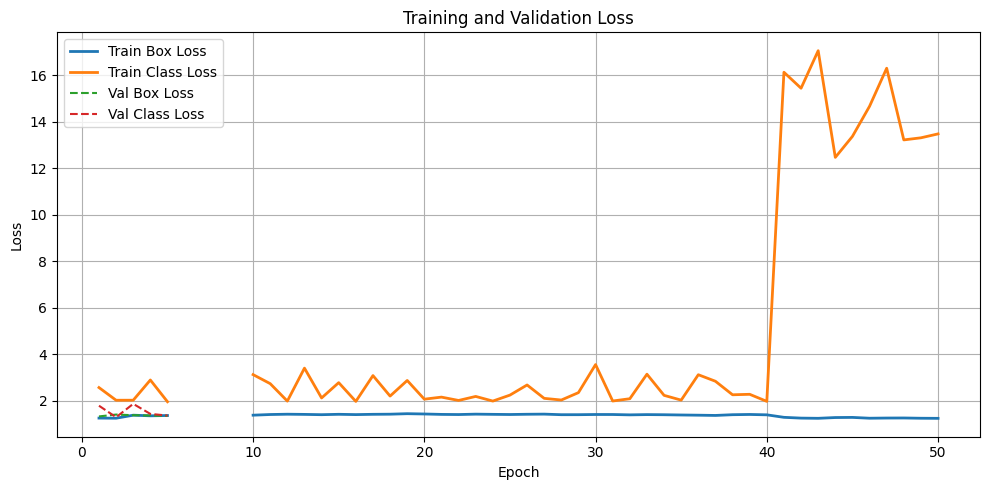

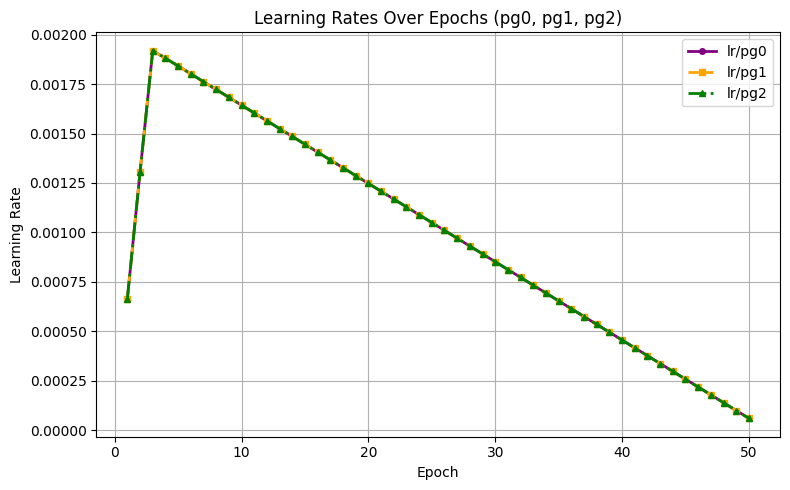

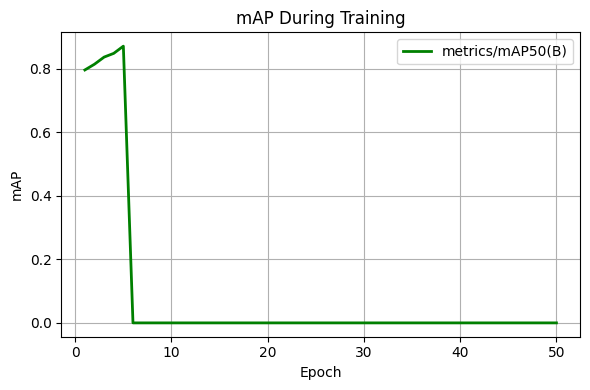

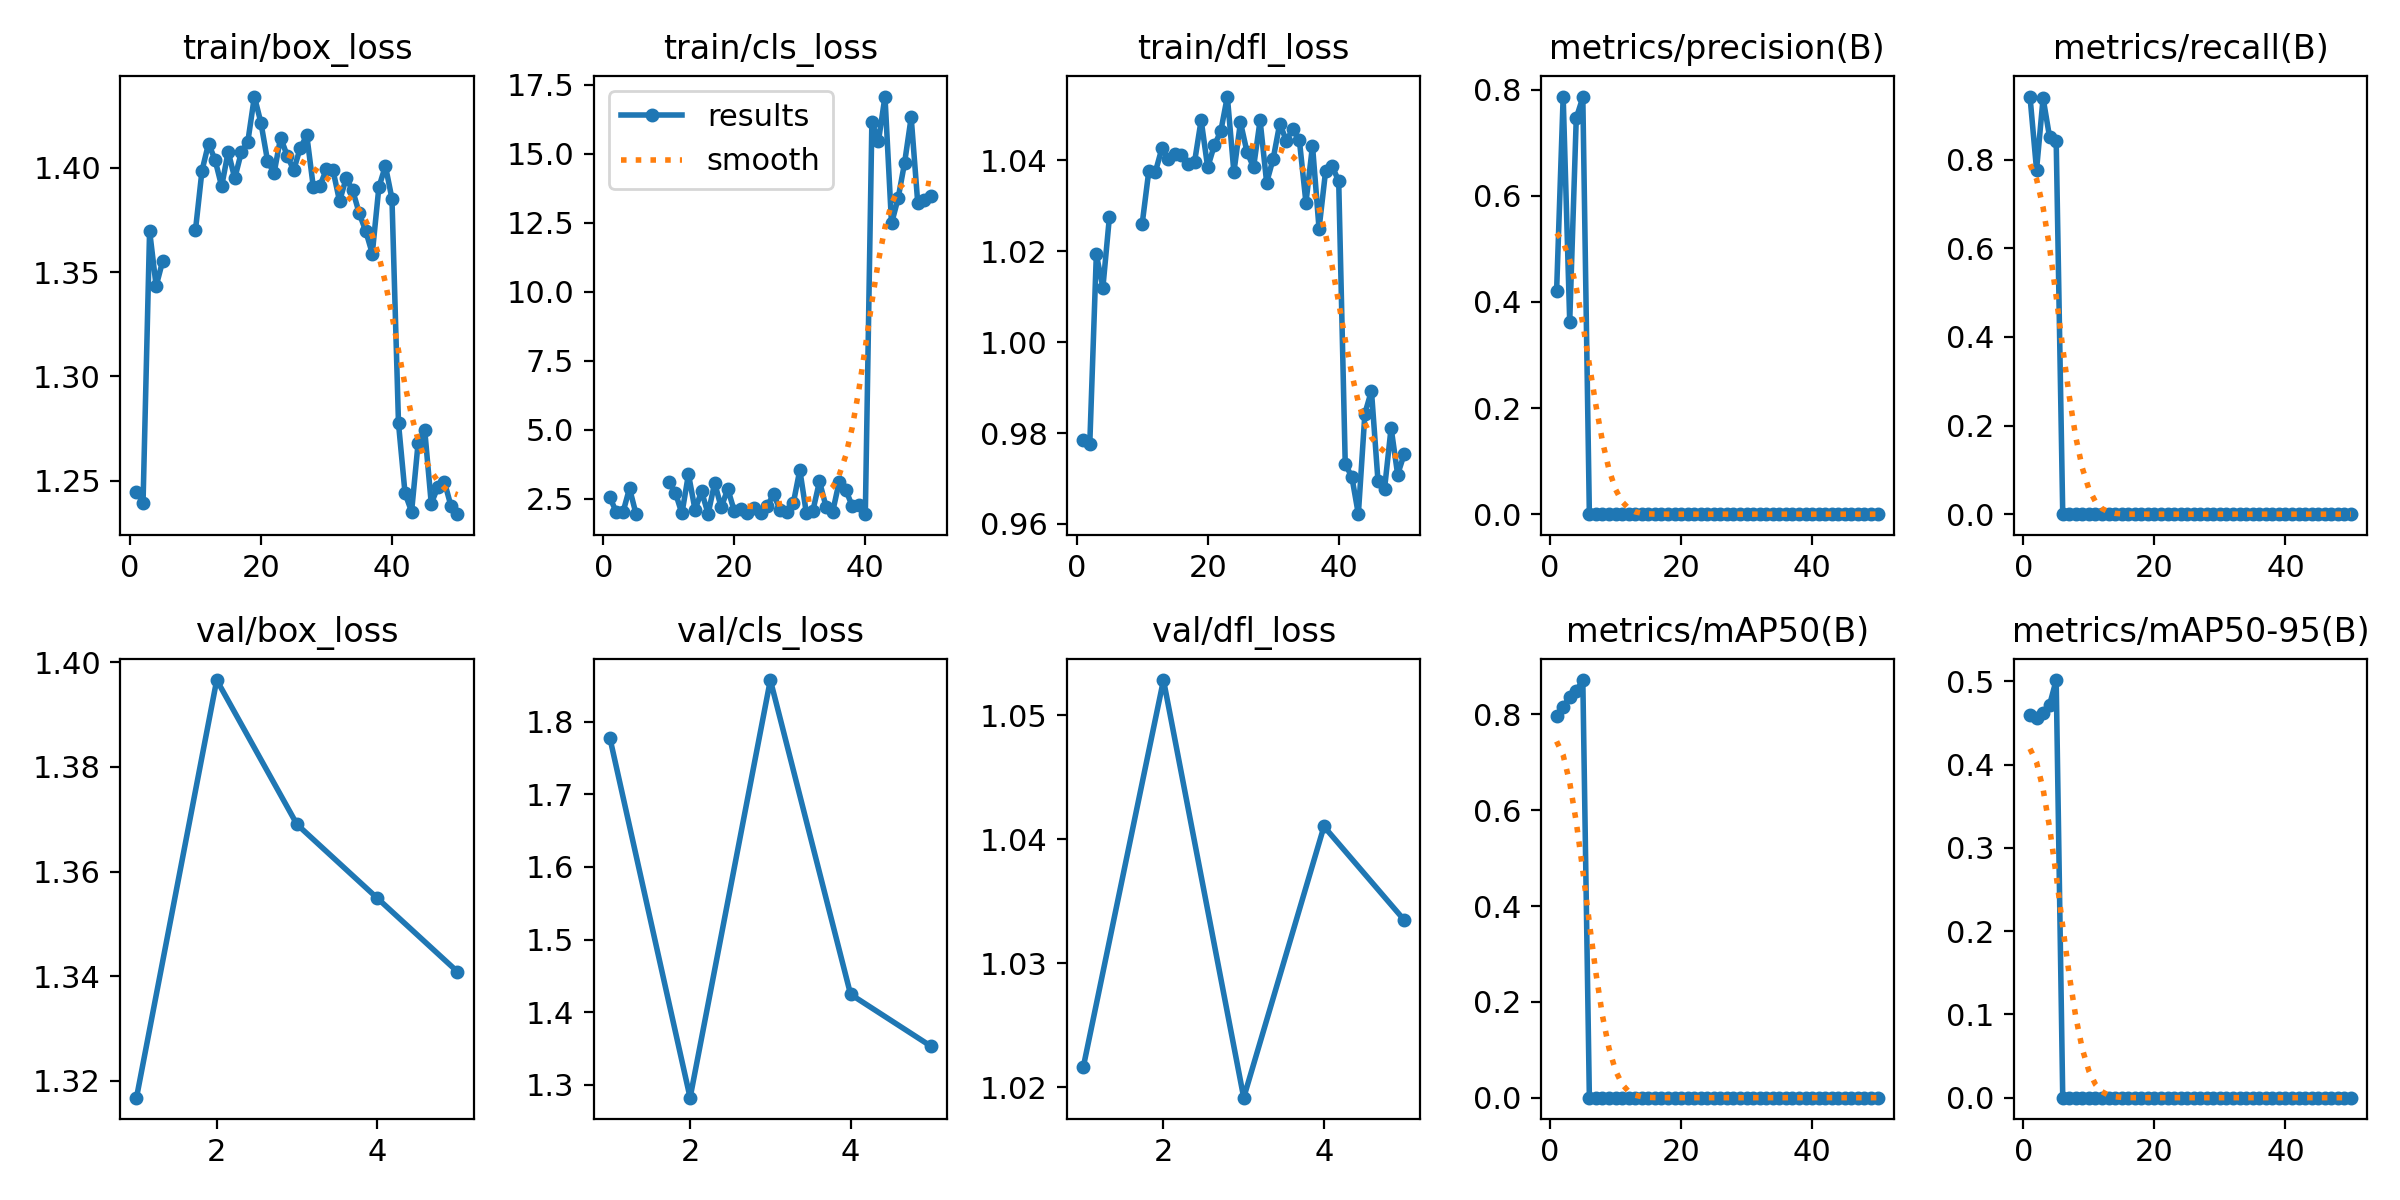

In [11]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Path to results.csv
results_path = WORK / f"student_it{it+1}" / "results.csv"

# Load CSV
df = pd.read_csv(results_path)

# Show available columns
print("Available columns:", df.columns.tolist())

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
colors = ['purple', 'orange', 'green']
styles = ['-', '--', '-.']
markers = ['o', 's', '^']

if lr_columns:
    plt.figure(figsize=(8, 5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")


# Plot mAP Curve (0.5 IoU)
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)"]  # version dependent
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(6, 4))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")



from PIL import Image
from IPython.display import display

results_img = WORK / f"student_it{it+1}" / "results.png"
img = Image.open(results_img)
display(img)

# Final Model Evaluation 

In [12]:
print("\nEvaluating …")
model   = YOLO(str(teacher_weights))
results = model.val(
    data=str(teacher_data_yaml_path),
    imgsz=640,
    batch=4,
    device=DEVICE,   # use same DEVICE string as before
    verbose=True
)

# Extract metrics depending on Ultralytics version
try:
    # new API
    metrics = results.results_dict
    print("\nValidation metrics")
    print(f"Precision (mP)   : {metrics.get('metrics/precision(B)', 0):.4f}")
    print(f"Recall (mR)      : {metrics.get('metrics/recall(B)', 0):.4f}")
    print(f"mAP@0.50         : {metrics.get('metrics/mAP50(B)', 0):.4f}")
    print(f"mAP@0.50:0.95    : {metrics.get('metrics/mAP50-95(B)', 0):.4f}")
except Exception as e:
    print("Could not parse metrics from results object:", e)
    print(results)

# import random, matplotlib.pyplot as plt

# # pick from test or valid images
# cands = list((WORK/"0_yolo_split"/"test"/"images").glob(".")) or list((WORK/"0_yolo_split"/"valid"/"images").glob("."))

# if cands:
#     imgs = random.sample(cands, min(4, len(cands)))  # pick up to 4 random images
#     fig, axes = plt.subplots(1, 4, figsize=(20, 6))
#     axes = axes.flatten()

#     for ax, img_path in zip(axes, imgs):
#         print("Visualising:", img_path.name)
#         pred = model.predict(
#             source=str(img_path),
#             imgsz=640,
#             conf=0.25,
#             device=DEVICE,
#             verbose=False
#         )[0]
#         ax.imshow(pred.plot()[:, :, ::-1])  # convert BGR to RGB
#         ax.axis("off")
#         ax.set_title(img_path.name, fontsize=10)

#     # hide unused axes if <4 images
#     for ax in axes[len(imgs):]:
#         ax.axis("off")

#     plt.tight_layout()
#     plt.show()

# else:
#     print("No images found for visualization.")


Evaluating …
Ultralytics 8.3.181 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2052.2±565.7 MB/s, size: 91.0 KB)


val: Scanning /kaggle/working/PSEUDO_STAC/Pseudo_Converted_Dataset/labeled_val/labels.cache... 79 images, 0 backgrounds, 0 corrupt: 100%|██████████| 79/79 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:03<00:00,  5.54it/s]
invalid value encountered in less
invalid value encountered in less


                   all         79       5726      0.779      0.843      0.865      0.505
Speed: 1.9ms preprocess, 27.5ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/detect/val

Validation metrics
Precision (mP)   : 0.7785
Recall (mR)      : 0.8435
mAP@0.50         : 0.8654
mAP@0.50:0.95    : 0.5045
